# Predicting Terrorist Attacks
## Weapon Classification

**Author:** Thomas Skowronek

**Date:** April 07, 2018

### Notebook Configuration

In [532]:
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [533]:
# Display up to 150 rows and columns
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

# Set the figure size for plots
mpl.rcParams['figure.figsize'] = (14.6, 9.0)

# Set the Seaborn default style for plots
sns.set()

# Set the color palette
sns.set_palette(sns.color_palette("muted"))

### Load the Datasets
Load the dataset created by the EDA notebook.

In [534]:
# Load the preprocessed GTD dataset
gtd_df = pd.read_csv('../data/gtd_eda_95t016.csv', low_memory=False, index_col = 0,
                      na_values=[''])

### Inspect the Structure
The cleansed data frame contains 48 attributes, one of which is used for the data frame index, and 110,844 observations.

In [535]:
# Display a summary of the data frame
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110844 entries, 199501000001 to 201701270001
Data columns (total 48 columns):
iyear               110844 non-null int64
imonth              110844 non-null int64
iday                110844 non-null int64
country_txt         110844 non-null object
region_txt          110844 non-null object
provstate           110844 non-null object
city                110844 non-null object
latitude            110844 non-null float64
longitude           110844 non-null float64
specificity         110844 non-null float64
summary             110844 non-null object
attacktype1_txt     110844 non-null object
targtype1_txt       110844 non-null object
targsubtype1_txt    110844 non-null object
corp1               110844 non-null object
target1             110844 non-null object
natlty1_txt         110844 non-null object
gname               110844 non-null object
nperpcap            110844 non-null float64
weaptype1_txt       110844 non-null object
weapsubtype

### Convert Attributes to Correct Data Type
Convert a subset of the data frame attributes to categorical, datatime and string to align with the GTD code book as executed previously in the EDA notebook.

In [536]:
# List of attributes that are categorical
cat_attrs = ['extended_txt', 'country_txt', 'region_txt', 'specificity', 'vicinity_txt',
             'crit1_txt', 'crit2_txt', 'crit3_txt', 'doubtterr_txt', 'multiple_txt',
             'success_txt', 'suicide_txt', 'attacktype1_txt', 'targtype1_txt', 
             'targsubtype1_txt', 'natlty1_txt', 'guncertain1_txt', 'individual_txt', 
             'claimed_txt', 'weaptype1_txt', 'weapsubtype1_txt', 'property_txt', 
             'ishostkid_txt', 'INT_LOG_txt', 'INT_IDEO_txt','INT_MISC_txt', 'INT_ANY_txt']

for cat in cat_attrs:
    gtd_df[cat] = gtd_df[cat].astype('category')

# Data time feature added during EDA
gtd_df['incident_date'] = pd.to_datetime(gtd_df['incident_date'])

# Necessary for label encoding below
gtd_df['gname'] = gtd_df['gname'].astype('str')
    
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110844 entries, 199501000001 to 201701270001
Data columns (total 48 columns):
iyear               110844 non-null int64
imonth              110844 non-null int64
iday                110844 non-null int64
country_txt         110844 non-null category
region_txt          110844 non-null category
provstate           110844 non-null object
city                110844 non-null object
latitude            110844 non-null float64
longitude           110844 non-null float64
specificity         110844 non-null category
summary             110844 non-null object
attacktype1_txt     110844 non-null category
targtype1_txt       110844 non-null category
targsubtype1_txt    110844 non-null category
corp1               110844 non-null object
target1             110844 non-null object
natlty1_txt         110844 non-null category
gname               110844 non-null object
nperpcap            110844 non-null float64
weaptype1_txt       110844 non-null categ

### Find the Major Groups
Get the list of terrorist groups that have 55 or more attacks.

In [537]:
# Calculate the number of attacks by group
groups = gtd_df['gname'].value_counts()

# Include groups with at least 55 attacks
groups = groups[groups > 54]

# Exclude unknown groups
group_list = groups.index[groups.index != 'Unknown']

# Subset the data to major groups
major_groups = gtd_df[gtd_df['gname'].isin(group_list)]

# Display the number of attacks by group
major_groups['gname'].value_counts()

Taliban                                                         6558
Islamic State of Iraq and the Levant (ISIL)                     4261
Al-Shabaab                                                      2669
Boko Haram                                                      2067
Communist Party of India - Maoist (CPI-Maoist)                  1766
Revolutionary Armed Forces of Colombia (FARC)                   1529
New People's Army (NPA)                                         1444
Maoists                                                         1411
Kurdistan Workers' Party (PKK)                                  1255
Tehrik-i-Taliban Pakistan (TTP)                                 1250
Al-Qaida in the Arabian Peninsula (AQAP)                         966
Liberation Tigers of Tamil Eelam (LTTE)                          950
Houthi extremists (Ansar Allah)                                  862
Al-Qaida in Iraq                                                 633
Donetsk People's Republic         

### Drop Text and Datetime Attributes
Remove the text and datetime attributes, which will not be used in the models.

In [538]:
major_groups = major_groups.drop(['provstate', 'city', 'summary', 'corp1', 'target1',
                                  'scite1', 'dbsource', 'incident_date'], axis=1)

major_groups.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43047 entries, 199501000001 to 201612310043
Data columns (total 40 columns):
iyear               43047 non-null int64
imonth              43047 non-null int64
iday                43047 non-null int64
country_txt         43047 non-null category
region_txt          43047 non-null category
latitude            43047 non-null float64
longitude           43047 non-null float64
specificity         43047 non-null category
attacktype1_txt     43047 non-null category
targtype1_txt       43047 non-null category
targsubtype1_txt    43047 non-null category
natlty1_txt         43047 non-null category
gname               43047 non-null object
nperpcap            43047 non-null float64
weaptype1_txt       43047 non-null category
weapsubtype1_txt    43047 non-null category
nkill               43047 non-null float64
nkillus             43047 non-null float64
nkillter            43047 non-null float64
nwound              43047 non-null float64
nwoundus   

### Standardize the Numeric Attributes
Adjust for differences in the range of the numeric attributes.

In [539]:
scaler = preprocessing.StandardScaler()

# List of numeric attributes
scale_attrs = ['nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

# Normalize the attributes in place
major_groups[scale_attrs] = scaler.fit_transform(major_groups[scale_attrs])

# View the transformation
major_groups[scale_attrs].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nperpcap,43047.0,-6.359070e-15,1.000012,-0.048863,-0.048863,-0.048863,-0.048863,175.344421
nkill,43047.0,-1.211440e-16,1.000012,-0.218733,-0.218733,-0.160528,-0.044119,87.088708
nkillus,43047.0,4.108215e-16,1.000012,-0.008724,-0.008724,-0.008724,-0.008724,147.644500
nkillter,43047.0,4.246914e-14,1.000012,-0.154393,-0.154393,-0.154393,-0.154393,59.987162
nwound,43047.0,2.148770e-15,1.000012,-0.075887,-0.075887,-0.075887,-0.040656,129.680434
nwoundus,43047.0,-2.079679e-15,1.000012,-0.023137,-0.023137,-0.023137,-0.023137,133.566825
nwoundte,43047.0,-3.460625e-14,1.000012,-0.096721,-0.096721,-0.096721,-0.096721,78.077587


### Encode the Target Attribute
Convert the text values of the terrorist groups to an encoded numeric value for the random forest models.

In [540]:
# Create the encoder
le = preprocessing.LabelEncoder()

# Fit the encoder to the target
le.fit(major_groups['gname'])

LabelEncoder()

In [541]:
# View the labels
list(le.classes_)

['Abu Sayyaf Group (ASG)',
 'Al-Aqsa Martyrs Brigade',
 "Al-Gama'at al-Islamiyya (IG)",
 'Al-Nusrah Front',
 'Al-Qaida',
 'Al-Qaida in Iraq',
 'Al-Qaida in the Arabian Peninsula (AQAP)',
 'Al-Qaida in the Islamic Maghreb (AQIM)',
 'Al-Shabaab',
 'Algerian Islamic Extremists',
 'Allied Democratic Forces (ADF)',
 'Anarchists',
 'Animal Liberation Front (ALF)',
 'Ansar Bayt al-Maqdis (Ansar Jerusalem)',
 'Ansar al-Sharia (Libya)',
 'Anti-Abortion extremists',
 'Armed Islamic Group (GIA)',
 "Asa'ib Ahl al-Haqq",
 'Baloch Liberation Army (BLA)',
 'Baloch Liberation Front (BLF)',
 'Baloch Republican Army (BRA)',
 'Bangladesh Nationalist Party (BNP)',
 'Bangsamoro Islamic Freedom Movement (BIFM)',
 'Barqa Province of the Islamic State',
 'Basque Fatherland and Freedom (ETA)',
 'Boko Haram',
 'Chechen Rebels',
 'Communist Party of India - Maoist (CPI-Maoist)',
 'Corsican National Liberation Front (FLNC)',
 'Corsican National Liberation Front- Historic Channel',
 'Democratic Front for the Liber

In [542]:
# View the encoded values for th terrorist group names
label_codes = le.transform(major_groups['gname'])
label_codes

array([15, 15, 15, ..., 96, 25, 61])

In [543]:
# Convert some integers into their category names
list(le.inverse_transform([0, 1, 2, 27]))

['Abu Sayyaf Group (ASG)',
 'Al-Aqsa Martyrs Brigade',
 "Al-Gama'at al-Islamiyya (IG)",
 'Communist Party of India - Maoist (CPI-Maoist)']

### Create Training and Testing Datasets
The original dataset is split into 80% training and 20% testing.

In [544]:
# Seed for reproducible results
seed = 1009

# Predictor variables
X = pd.get_dummies(major_groups.drop(['gname'], axis=1), drop_first=True)

# Labels
y = label_codes

# Create an 80/20 split for training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, stratify = y)

### Initial Random Forest Model
Create the initial model using 100 estimators.

In [545]:
start = time.time()

# Create the model
rf1 = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = seed)

# Fit it to the training data
rf1.fit(X_train, y_train)

end = time.time()
print("Execution Seconds: {}".format((end - start)))
print("\n")
print(rf1)

Execution Seconds: 4.335899114608765


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1009, verbose=0,
            warm_start=False)


### Feature Importance
Display the top 50 features by importance in descending order.

In [546]:
# Get the modified column names with one hot encoding
column_names = list(X_train.columns.values)

# Create a descending sorted list of variables by featur importance
var_imp = sorted(zip(map(lambda x: x, rf1.feature_importances_), column_names), 
             reverse = True)

print("\nNumber of Features: {}".format(len(var_imp)))

print("\nFeatures Ranking - Top 50:\n")
for f in var_imp[0:50]:
    print(f)


Number of Features: 603

Features Ranking - Top 50:

(0.087249094998451807, 'latitude')
(0.086527538470334134, 'longitude')
(0.040965442988175206, 'iyear')
(0.033517181497532363, 'region_txt_South Asia')
(0.022723377886245847, 'INT_IDEO_txt_YES')
(0.022439174305131301, 'region_txt_Middle East & North Africa')
(0.022361021893889586, 'INT_ANY_txt_YES')
(0.019951694536712278, 'natlty1_txt_Iraq')
(0.019722381100048009, 'country_txt_Somalia')
(0.018071610695185609, 'region_txt_Sub-Saharan Africa')
(0.017443932635588487, 'country_txt_Iraq')
(0.016287435428150886, 'natlty1_txt_India')
(0.016043516049272035, 'INT_LOG_txt_UKNOWN')
(0.01570830603462409, 'iday')
(0.015607292792307905, 'INT_ANY_txt_UKNOWN')
(0.015123946294818027, 'country_txt_Nigeria')
(0.015019914874421822, 'imonth')
(0.014684356344748066, 'country_txt_Pakistan')
(0.014238596568301938, 'natlty1_txt_Pakistan')
(0.013678514180993249, 'INT_IDEO_txt_UKNOWN')
(0.013013589919364174, 'country_txt_India')
(0.012199130311359876, 'natlty1

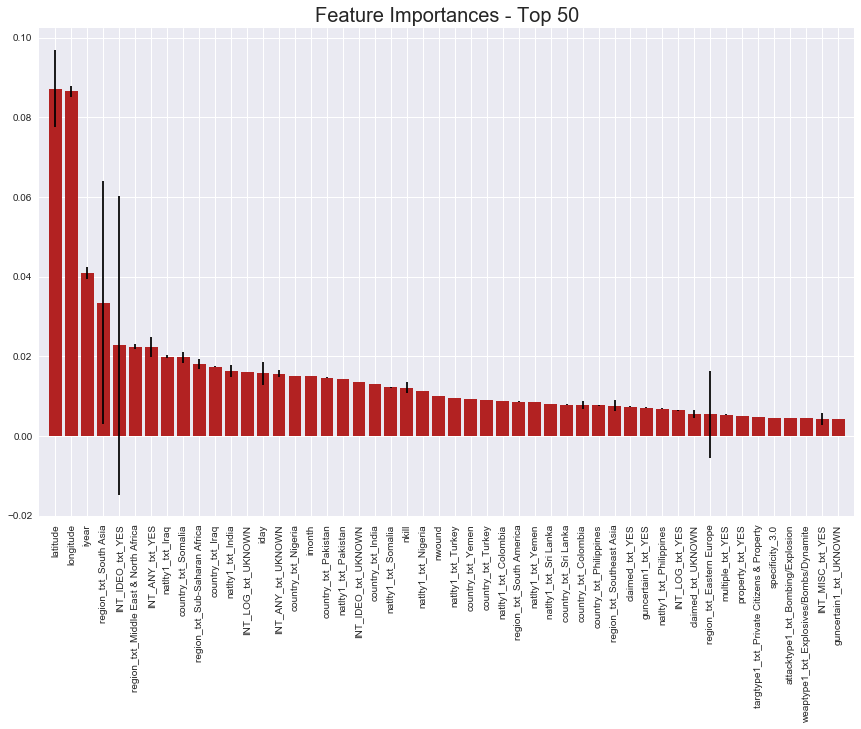

In [547]:
# Get the features, standard deviation and indices
importances = rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf1.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Filter to the top 50
top_n = 50
top_n_importances = importances[indices][0:top_n]
top_n_std = std[0:top_n]
top_n_indices = indices[0:top_n]

# Create a list of x labels
x_labels = [column_names[t] for t in top_n_indices]

# Plot the results
plt.figure()
plt.title("Feature Importances - Top 50",  fontsize=20)
plt.bar(range(top_n), top_n_importances, color="firebrick", yerr = top_n_std, align="center")
plt.xticks(rotation=90)
plt.xticks(range(top_n), x_labels)
plt.xlim([-1, top_n])
plt.show()

### Model Performance
Calculate the accuracy, precision, and F1 scores for the model.

In [548]:
# Predict labels on the test dataset
pred_lables1 = rf1.predict(X_test)

# Calculate the accuracy of the model
acc_score1 = accuracy_score(y_test, pred_lables1)
print("\nAccuracy: {}".format(acc_score1))

# Calculate the precision of the model
prec_score1 = precision_score(y_test, pred_lables1, average='weighted')
print("\nPrecision: {}".format(prec_score1))

# Calculate the precision of the model
rcll_score1 = recall_score(y_test, pred_lables1, average='weighted')
print("\nRecall: {}".format(rcll_score1))

# Calculate the F1 of the model
f1_score1 = f1_score(y_test, pred_lables1, average='weighted')
print("\nF1: {}".format(f1_score1))


Accuracy: 0.9308943089430894

Precision: 0.9308460369642759

Recall: 0.9308943089430894

F1: 0.9263998944054898


### References

Albon, C. (2017). Convert Pandas categorical data for scikit-learn Retrieved from https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/

Keen, B. (2017). Feature scaling with scikit-learn Retrieved from http://benalexkeen.com/feature-scaling-with-scikit-learn/

Saabas, A. (2014). Selecting good features – Part III: random forests Retrieved from http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

scikit-learn. (n.d.). Feature importances with forests of trees Retrieved from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py